### Import the required libraries.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab import files, drive
import cv2, glob, re, io, zipfile
from os import listdir
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers.experimental import preprocessing
from keras.models import Model, load_model
from tensorflow import keras
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report

### Read the images and annotation.




In [17]:
uploaded = files.upload()

data = pd.read_csv(io.BytesIO(uploaded['annotations.csv']))

Saving annotations.csv to annotations.csv


In [18]:
data.head()

,image_name,wrinkles,freakles,glasses,hair_color,hair_top,no_face_shown_or_not_human
0,87.jpg,1,0,0,2,0,0
1,110.jpg,1,0,0,2,0,0
2,117.jpg,1,1,0,6,2,0
3,358.jpg,0,0,0,6,2,0
4,389.jpg,0,0,2,6,0,0


In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
filename = "/content/drive/MyDrive/all.zip"
with zipfile.ZipFile(filename, 'r') as zipp:
  zipp.extractall()
  zipp.close()

In [8]:
# for sorting 
digits = re.compile(r'(\d+)')
_nsre = re.compile('([0-9]+)')

def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower()
            for text in re.split(_nsre, s)] 

def tokenize(filename):
    return tuple(int(token) if match else token
                 for token, match in
                 ((fragment, digits.search(fragment))
                  for fragment in digits.split(filename)))

In [10]:
items = glob.glob('/content/all/*')
items.sort(key=natural_sort_key)

aaa = []
for each_image in items:
  # if each_image.endswith(".jpg") or each_image.endswith(".jpeg"):
    image = cv2.imread(each_image)
    image = cv2.resize(image, (96,96))
    aaa.append(image)


A sample file name: 87.jpg


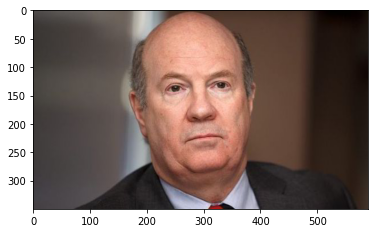

In [11]:
# path of the image files in the drive
dir_struct = '/content/all/'
file_list = listdir(dir_struct) # it will return all the image file names as a list
file_list.sort(key=natural_sort_key)
print('A sample file name: {}'.format(file_list[0]))

# Change color to RGB from OpenCV's BGR format since this library uses BGR format [rather than RGB] for historical purposes
image = cv2.imread(dir_struct+file_list[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [ ]:
flattened_image = image.reshape((-1,3)) 
flattened_image = np.float32(flattened_image)

Specifying the labels

In [19]:
wrinkles = ['have_wrinkles','no_wrinkles']
freakles = ['have_freakles', 'no_freakles']
glasses = ['do_not_wear', 'wear_normal','wear_sunglasses']
hair_color = ['brown', 'black', 'gray', 'blonde', 'red', 'white', 'mixed','other','not_visible']
hair_top = ['bald_or_shaved', 'has_few_hair', 'has_thick_hair', 'not_visible']

labels_wrinkles = []
labels_freakles = []
labels_glasses = []
labels_hair_color = []
labels_hair_top = []

for i in range(len(file_list)):
    labels_wrinkles.append(data['wrinkles'][i])
    labels_freakles.append(data['freakles'][i])
    labels_glasses.append(data['glasses'][i])
    labels_hair_color.append(data['hair_color'][i])
    labels_hair_top.append(data['hair_top'][i])

In [20]:
# saving the annotation file where image names are mapped with labels
df = pd.DataFrame({'image_name':file_list, 'wrinkles':labels_wrinkles, 'freakles':labels_freakles, 'glasses':labels_glasses, 'hair_color':labels_hair_color, 'hair_top':labels_hair_top}, 
                  columns=['image_name', 'wrinkles', 'freakles','glasses','hair_color','hair_top'])
df.to_csv('/content/sample_annotation.csv', index=False)

In [21]:
df.head()

,image_name,wrinkles,freakles,glasses,hair_color,hair_top
0,87.jpg,1,0,0,2,0
1,110.jpg,1,0,0,2,0
2,117.jpg,1,1,0,6,2
3,358.jpg,0,0,0,6,2
4,389.jpg,0,0,2,6,0


Information regarding the proportions for each labels.

In [22]:
df  = pd.read_csv('/content/sample_annotation.csv')
print('Number of images: ', df.shape[0])
print('The proportion of the different wrinkles labels: ')
print(df['wrinkles'].value_counts())

print('The proportion of the different freakles labels: ')
print(df['freakles'].value_counts())

print('The proportion of the different glasses labels: ')
print(df['glasses'].value_counts())

print('The proportion of the different hair_color labels: ')
print(df['hair_color'].value_counts())

print('The proportion of the different hair_top labels: ')
print(df['hair_top'].value_counts())


Number of images:  1991
The proportion of the different wrinkles labels: 
0    1631
1     360
Name: wrinkles, dtype: int64
The proportion of the different freakles labels: 
0    1944
1      47
Name: freakles, dtype: int64
The proportion of the different glasses labels: 
0    1779
1     185
2      27
Name: glasses, dtype: int64
The proportion of the different hair_color labels: 
1    791
0    467
3    279
2    190
8     91
5     81
6     46
7     27
4     19
Name: hair_color, dtype: int64
The proportion of the different hair_top labels: 
2    1451
1     212
3     167
0     161
Name: hair_top, dtype: int64


In [23]:
image_list = [] # this list will hold all the images
#for i in range(1):
for i in range(df.shape[0]): # read the image one by one
    image = cv2.imread(dir_struct+df.iloc[i]['image_name'])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # BGR to RGB convert
    image = cv2.resize(image, (32,32), interpolation = cv2.INTER_AREA) # resizing all images to 32x32: NOT ideal but need to be uniform in order to apply the algorithm
                                                                                                                        # this actually ensures all the features [pixel values] will be of same size
    image_list.append(image) # appending the read image to a list

In [24]:
df['image'] = image_list # creating a new column that holds all the images

### Facial Attribute 1 - Wrinkles

In [25]:
# Data splitting
X = np.array(image_list)
Y = np.array(df['wrinkles'])
train_images, test_images, train_labels, test_labels = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
print('Training dataset shape: {}'.format(train_images.shape))
print('Testing dataset shape: {}'.format(test_images.shape))

Training dataset shape: (1592, 32, 32, 3)
Testing dataset shape: (399, 32, 32, 3)


In [26]:
# Normalize the data
train_images, test_images = train_images / 255.0, test_images / 255.0

### Model - 1

In [28]:
model_1 = models.Sequential()

model_1.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu", input_shape=(32,32,3)))
model_1.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model_1.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))  ## END BLOCK 1
model_1.add(layers.Conv2D(filters=128,kernel_size=(3,3),padding="same", activation="relu"))
model_1.add(layers.Conv2D(filters=128,kernel_size=(3,3),padding="same", activation="relu"))
model_1.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))   ## END BLOCK 2
model_1.add(layers.Conv2D(filters=256,kernel_size=(3,3),padding="same", activation="relu"))
model_1.add(layers.Conv2D(filters=256,kernel_size=(3,3),padding="same", activation="relu"))
model_1.add(layers.Conv2D(filters=256,kernel_size=(3,3),padding="same", activation="relu"))
model_1.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))    ## END BLOCK 3 
model_1.add(layers.Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
model_1.add(layers.Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
model_1.add(layers.Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
model_1.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))    ## END BLOCK 4 
model_1.add(layers.Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
model_1.add(layers.Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
model_1.add(layers.Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
model_1.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))    ## END BLOCK 5 
model_1.add(layers.Flatten())    ## converting to vector 
model_1.add(layers.Dense(4096, activation="relu"))    ## 1st FC layer 
model_1.add(layers.Dense(4096, activation="relu"))    ## 2st FC layer 
model_1.add(layers.Dense(10, activation="softmax"))    ## output layer 


model_1.compile(optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 8, 8, 256)        

### Training model-1

Epoch 1/5
4/4 [==============================] - 147s 34s/step - loss: 0.6163 - accuracy: 0.8197 - val_loss: 0.6967 - val_accuracy: 0.8170

Epoch 00001: saving model to Model_1-01-0.8170.h5
Epoch 2/5
4/4 [==============================] - 146s 33s/step - loss: 0.6492 - accuracy: 0.8197 - val_loss: 0.5005 - val_accuracy: 0.8170

Epoch 00002: saving model to Model_1-02-0.8170.h5
Epoch 3/5
4/4 [==============================] - 139s 31s/step - loss: 0.4852 - accuracy: 0.8197 - val_loss: 0.4859 - val_accuracy: 0.8170

Epoch 00003: saving model to Model_1-03-0.8170.h5
Epoch 4/5
4/4 [==============================] - 132s 30s/step - loss: 0.4756 - accuracy: 0.8197 - val_loss: 0.4837 - val_accuracy: 0.8170

Epoch 00004: saving model to Model_1-04-0.8170.h5
Epoch 5/5
4/4 [==============================] - 130s 30s/step - loss: 0.4763 - accuracy: 0.8197 - val_loss: 0.4838 - val_accuracy: 0.8170

Epoch 00005: saving model to Model_1-05-0.8170.h5
13/13 - 3s - loss: 0.4838 - accuracy: 0.8170
0.817

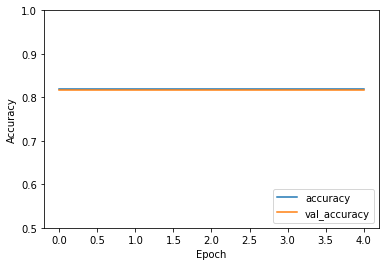

In [ ]:
# define the checkpoint
filepath = "Model_1-{epoch:02d}-{val_accuracy:.4f}.h5"
checkpoint = ModelCheckpoint(  
    filepath,
    monitor="val_accuracy",
    verbose=1,
    save_best_only=False,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch")

callbacks_list = [checkpoint]

# Training
history = model_1.fit(train_images, train_labels, epochs=5, batch_size=512,
                    validation_data=(test_images, test_labels), callbacks=callbacks_list)

# Validation
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model_1.evaluate(test_images,  test_labels, verbose=2)

print(test_acc)

In [29]:

#specify the saved model from before
filepath = "/content/Model_1-05-0.8170.h5"

# load the model
new_model = load_model(filepath)

y_pred1 = new_model.predict(test_images)
y_pred = np.argmax(y_pred1, axis=1)

print(classification_report(test_labels, y_pred))

# Print f1, precision, and recall scores
print(precision_score(test_labels, y_pred , average="macro"))
print(recall_score(test_labels, y_pred , average="macro"))

print(f1_score(test_labels, y_pred , average="macro"))
print(f1_score(test_labels, y_pred , average="micro"))
print(f1_score(test_labels, y_pred , average="weighted"))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90       326
           1       0.00      0.00      0.00        73

    accuracy                           0.82       399
   macro avg       0.41      0.50      0.45       399
weighted avg       0.67      0.82      0.73       399

0.40852130325814534
0.5
0.44965517241379305
0.8170426065162907
0.7347748682049952


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Facial attribute 2 - Freakles

In [ ]:
# Data splitting
X = np.array(image_list)
Y = np.array(df['freakles'])
train_images, test_images, train_labels, test_labels = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
print('Training dataset shape: {}'.format(train_images.shape))
print('Testing dataset shape: {}'.format(test_images.shape))

Training dataset shape: (1592, 32, 32, 3)
Testing dataset shape: (399, 32, 32, 3)


In [ ]:
# Normalize the data
train_images, test_images = train_images / 255.0, test_images / 255.0

### Model - 2 

In [ ]:
model_2 = models.Sequential()

model_2.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu", input_shape=(32,32,3)))
model_2.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model_2.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))  ## END BLOCK 1
model_2.add(layers.Conv2D(filters=128,kernel_size=(3,3),padding="same", activation="relu"))
model_2.add(layers.Conv2D(filters=128,kernel_size=(3,3),padding="same", activation="relu"))
model_2.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))   ## END BLOCK 2
model_2.add(layers.Conv2D(filters=256,kernel_size=(3,3),padding="same", activation="relu"))
model_2.add(layers.Conv2D(filters=256,kernel_size=(3,3),padding="same", activation="relu"))
model_2.add(layers.Conv2D(filters=256,kernel_size=(3,3),padding="same", activation="relu"))
model_2.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))    ## END BLOCK 3 
model_2.add(layers.Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
model_2.add(layers.Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
model_2.add(layers.Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
model_2.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))    ## END BLOCK 4 
model_2.add(layers.Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
model_2.add(layers.Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
model_2.add(layers.Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
model_2.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))    ## END BLOCK 5 
model_2.add(layers.Flatten())    ## converting to vector 
model_2.add(layers.Dense(4096, activation="relu"))    ## 1st FC layer 
model_2.add(layers.Dense(4096, activation="relu"))    ## 2st FC layer 
model_2.add(layers.Dense(10, activation="softmax"))    ## output layer 


model_2.compile(optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 8, 8, 256)        

### Training model - 2

Epoch 1/5
4/4 [==============================] - 155s 36s/step - loss: 2.2949 - accuracy: 0.4934 - val_loss: 2.1399 - val_accuracy: 0.9774

Epoch 00001: saving model to Model_2-01-0.9774.h5
Epoch 2/5
4/4 [==============================] - 141s 31s/step - loss: 1.8917 - accuracy: 0.9767 - val_loss: 0.1631 - val_accuracy: 0.9774

Epoch 00002: saving model to Model_2-02-0.9774.h5
Epoch 3/5
4/4 [==============================] - 135s 31s/step - loss: 0.3436 - accuracy: 0.9771 - val_loss: 0.5756 - val_accuracy: 0.9774

Epoch 00003: saving model to Model_2-03-0.9774.h5
Epoch 4/5
4/4 [==============================] - 146s 34s/step - loss: 0.6831 - accuracy: 0.9747 - val_loss: 0.1718 - val_accuracy: 0.9774

Epoch 00004: saving model to Model_2-04-0.9774.h5
Epoch 5/5
4/4 [==============================] - 148s 34s/step - loss: 0.1801 - accuracy: 0.9765 - val_loss: 0.2935 - val_accuracy: 0.9774

Epoch 00005: saving model to Model_2-05-0.9774.h5
13/13 - 3s - loss: 0.2935 - accuracy: 0.9774
0.977

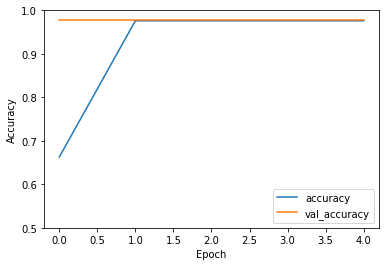

In [ ]:
# define the checkpoint
filepath = "Model_2-{epoch:02d}-{val_accuracy:.4f}.h5"
checkpoint = ModelCheckpoint(  
    filepath,
    monitor="val_accuracy",
    verbose=1,
    save_best_only=False,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch")

callbacks_list = [checkpoint]

# Training
history = model_2.fit(train_images, train_labels, epochs=5, batch_size=512,
                    validation_data=(test_images, test_labels), callbacks=callbacks_list)

# Validation
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model_2.evaluate(test_images,  test_labels, verbose=2)

print(test_acc)

In [ ]:

#specify the saved model from before
filepath = "/content/Model_2-05-0.9774.h5"

# load the model
new_model = load_model(filepath)

y_pred1 = new_model.predict(test_images)
y_pred = np.argmax(y_pred1, axis=1)

print(classification_report(test_labels, y_pred))

# Print f1, precision, and recall scores
print(precision_score(test_labels, y_pred , average="macro"))
print(recall_score(test_labels, y_pred , average="macro"))

print(f1_score(test_labels, y_pred , average="macro"))
print(f1_score(test_labels, y_pred , average="micro"))
print(f1_score(test_labels, y_pred , average="weighted"))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       390
           1       0.00      0.00      0.00         9

    accuracy                           0.98       399
   macro avg       0.49      0.50      0.49       399
weighted avg       0.96      0.98      0.97       399

0.48872180451127817
0.5
0.494296577946768
0.9774436090225563
0.9662940621515765


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Facial attribute 3 - Glasses

In [ ]:
# Data splitting
X = np.array(image_list)
Y = np.array(df['glasses'])
train_images, test_images, train_labels, test_labels = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
print('Training dataset shape: {}'.format(train_images.shape))
print('Testing dataset shape: {}'.format(test_images.shape))

Training dataset shape: (1592, 32, 32, 3)
Testing dataset shape: (399, 32, 32, 3)


In [ ]:
# Normalize the data
train_images, test_images = train_images / 255.0, test_images / 255.0

### Model - 3

In [ ]:
model_3 = models.Sequential()

model_3.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu", input_shape=(32,32,3)))
model_3.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model_3.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))  ## END BLOCK 1
model_3.add(layers.Conv2D(filters=128,kernel_size=(3,3),padding="same", activation="relu"))
model_3.add(layers.Conv2D(filters=128,kernel_size=(3,3),padding="same", activation="relu"))
model_3.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))   ## END BLOCK 2
model_3.add(layers.Conv2D(filters=256,kernel_size=(3,3),padding="same", activation="relu"))
model_3.add(layers.Conv2D(filters=256,kernel_size=(3,3),padding="same", activation="relu"))
model_3.add(layers.Conv2D(filters=256,kernel_size=(3,3),padding="same", activation="relu"))
model_3.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))    ## END BLOCK 3 
model_3.add(layers.Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
model_3.add(layers.Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
model_3.add(layers.Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
model_3.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))    ## END BLOCK 4 
model_3.add(layers.Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
model_3.add(layers.Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
model_3.add(layers.Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
model_3.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))    ## END BLOCK 5 
model_3.add(layers.Flatten())    ## converting to vector 
model_3.add(layers.Dense(4096, activation="relu"))    ## 1st FC layer 
model_3.add(layers.Dense(4096, activation="relu"))    ## 2st FC layer 
model_3.add(layers.Dense(10, activation="softmax"))    ## output layer 


model_3.compile(optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model_3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 8, 8, 256)        

### Training model - 3

Epoch 1/5
4/4 [==============================] - 148s 33s/step - loss: 2.2968 - accuracy: 0.4524 - val_loss: 2.1990 - val_accuracy: 0.9048

Epoch 00001: saving model to Model_3-01-0.9048.h5
Epoch 2/5
4/4 [==============================] - 145s 33s/step - loss: 2.0507 - accuracy: 0.8939 - val_loss: 0.5372 - val_accuracy: 0.9048

Epoch 00002: saving model to Model_3-02-0.9048.h5
Epoch 3/5
4/4 [==============================] - 174s 40s/step - loss: 0.7900 - accuracy: 0.8984 - val_loss: 0.4653 - val_accuracy: 0.9048

Epoch 00003: saving model to Model_3-03-0.9048.h5
Epoch 4/5
4/4 [==============================] - 155s 35s/step - loss: 0.5386 - accuracy: 0.8911 - val_loss: 0.6154 - val_accuracy: 0.9048

Epoch 00004: saving model to Model_3-04-0.9048.h5
Epoch 5/5
4/4 [==============================] - 161s 36s/step - loss: 0.5471 - accuracy: 0.8932 - val_loss: 0.4013 - val_accuracy: 0.9048

Epoch 00005: saving model to Model_3-05-0.9048.h5
13/13 - 3s - loss: 0.4013 - accuracy: 0.9048
0.904

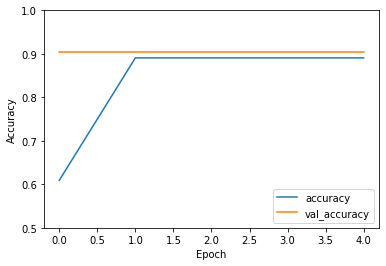

In [ ]:
# define the checkpoint
filepath = "Model_3-{epoch:02d}-{val_accuracy:.4f}.h5"
checkpoint = ModelCheckpoint(  
    filepath,
    monitor="val_accuracy",
    verbose=1,
    save_best_only=False,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch")

callbacks_list = [checkpoint]

# Training
history = model_3.fit(train_images, train_labels, epochs=5, batch_size=512,
                    validation_data=(test_images, test_labels), callbacks=callbacks_list)

# Validation
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model_3.evaluate(test_images,  test_labels, verbose=2)

print(test_acc)

In [ ]:

#specify the saved model from before
filepath = "/content/Model_3-05-0.9048.h5"

# load the model
new_model = load_model(filepath)

y_pred1 = new_model.predict(test_images)
y_pred = np.argmax(y_pred1, axis=1)

print(classification_report(test_labels, y_pred))

# Print f1, precision, and recall scores
print(precision_score(test_labels, y_pred , average="macro"))
print(recall_score(test_labels, y_pred , average="macro"))

print(f1_score(test_labels, y_pred , average="macro"))
print(f1_score(test_labels, y_pred , average="micro"))
print(f1_score(test_labels, y_pred , average="weighted"))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95       361
           1       0.00      0.00      0.00        34
           2       0.00      0.00      0.00         4

    accuracy                           0.90       399
   macro avg       0.30      0.33      0.32       399
weighted avg       0.82      0.90      0.86       399

0.30158730158730157
0.3333333333333333
0.3166666666666667
0.9047619047619048
0.8595238095238097


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Facial attribute 4 - Hair Color

In [ ]:
# Data splitting
X = np.array(image_list)
Y = np.array(df['hair_color'])
train_images, test_images, train_labels, test_labels = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
print('Training dataset shape: {}'.format(train_images.shape))
print('Testing dataset shape: {}'.format(test_images.shape))

Training dataset shape: (1592, 32, 32, 3)
Testing dataset shape: (399, 32, 32, 3)


In [ ]:
# Normalize the data
train_images, test_images = train_images / 255.0, test_images / 255.0

### Model - 4

In [ ]:
model_4 = models.Sequential()

model_4.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu", input_shape=(32,32,3)))
model_4.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model_4.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))  ## END BLOCK 1
model_4.add(layers.Conv2D(filters=128,kernel_size=(3,3),padding="same", activation="relu"))
model_4.add(layers.Conv2D(filters=128,kernel_size=(3,3),padding="same", activation="relu"))
model_4.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))   ## END BLOCK 2
model_4.add(layers.Conv2D(filters=256,kernel_size=(3,3),padding="same", activation="relu"))
model_4.add(layers.Conv2D(filters=256,kernel_size=(3,3),padding="same", activation="relu"))
model_4.add(layers.Conv2D(filters=256,kernel_size=(3,3),padding="same", activation="relu"))
model_4.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))    ## END BLOCK 3 
model_4.add(layers.Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
model_4.add(layers.Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
model_4.add(layers.Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
model_4.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))    ## END BLOCK 4 
model_4.add(layers.Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
model_4.add(layers.Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
model_4.add(layers.Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
model_4.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))    ## END BLOCK 5 
model_4.add(layers.Flatten())    ## converting to vector 
model_4.add(layers.Dense(4096, activation="relu"))    ## 1st FC layer 
model_4.add(layers.Dense(4096, activation="relu"))    ## 2st FC layer 
model_4.add(layers.Dense(10, activation="softmax"))    ## output layer 


model_4.compile(optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model_4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 256)         2

### Training model - 4

Epoch 1/5
4/4 [==============================] - 178s 41s/step - loss: 2.2995 - accuracy: 0.2445 - val_loss: 2.2458 - val_accuracy: 0.4010

Epoch 00001: saving model to Model_4-01-0.4010.h5
Epoch 2/5
4/4 [==============================] - 179s 41s/step - loss: 2.1678 - accuracy: 0.3981 - val_loss: 1.9853 - val_accuracy: 0.4010

Epoch 00002: saving model to Model_4-02-0.4010.h5
Epoch 3/5
4/4 [==============================] - 214s 46s/step - loss: 1.8759 - accuracy: 0.4002 - val_loss: 1.8471 - val_accuracy: 0.2281

Epoch 00003: saving model to Model_4-03-0.2281.h5
Epoch 4/5
4/4 [==============================] - 184s 42s/step - loss: 1.8397 - accuracy: 0.2423 - val_loss: 1.7474 - val_accuracy: 0.2281

Epoch 00004: saving model to Model_4-04-0.2281.h5
Epoch 5/5
4/4 [==============================] - 192s 45s/step - loss: 1.7633 - accuracy: 0.2678 - val_loss: 1.6878 - val_accuracy: 0.4010

Epoch 00005: saving model to Model_4-05-0.4010.h5
13/13 - 6s - loss: 1.6878 - accuracy: 0.4010
0.401

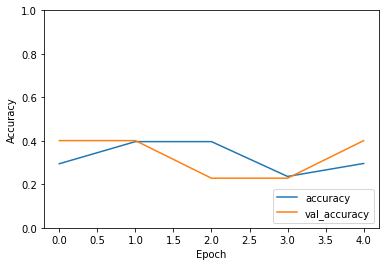

In [ ]:
# define the checkpoint
filepath = "Model_4-{epoch:02d}-{val_accuracy:.4f}.h5"
checkpoint = ModelCheckpoint(  
    filepath,
    monitor="val_accuracy",
    verbose=1,
    save_best_only=False,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch")

callbacks_list = [checkpoint]

# Training
history = model_4.fit(train_images, train_labels, epochs=5, batch_size=512,
                    validation_data=(test_images, test_labels), callbacks=callbacks_list)

# Validation
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model_4.evaluate(test_images,  test_labels, verbose=2)

print(test_acc)

In [ ]:

#specify the saved model from before
filepath = "/content/Model_4-05-0.4010.h5"

# load the model
new_model = load_model(filepath)

y_pred1 = new_model.predict(test_images)
y_pred = np.argmax(y_pred1, axis=1)

print(classification_report(test_labels, y_pred))

# Print f1, precision, and recall scores
print(precision_score(test_labels, y_pred , average="macro"))
print(recall_score(test_labels, y_pred , average="macro"))

print(f1_score(test_labels, y_pred , average="macro"))
print(f1_score(test_labels, y_pred , average="micro"))
print(f1_score(test_labels, y_pred , average="weighted"))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.40      1.00      0.57       160
           2       0.00      0.00      0.00        40
           3       0.00      0.00      0.00        54
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00        23
           6       0.00      0.00      0.00         7
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        18

    accuracy                           0.40       399
   macro avg       0.04      0.11      0.06       399
weighted avg       0.16      0.40      0.23       399

0.04455583402951824
0.1111111111111111
0.06360564500099383
0.40100250626566414
0.22955420752238379


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Facial attribute 5 - Hair top

In [ ]:
# Data splitting
X = np.array(image_list)
Y = np.array(df['hair_top'])
train_images, test_images, train_labels, test_labels = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
print('Training dataset shape: {}'.format(train_images.shape))
print('Testing dataset shape: {}'.format(test_images.shape))

Training dataset shape: (1592, 32, 32, 3)
Testing dataset shape: (399, 32, 32, 3)


In [ ]:
# Normalize the data
train_images, test_images = train_images / 255.0, test_images / 255.0

### Model - 5

In [ ]:
model_5 = models.Sequential()

model_5.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu", input_shape=(32,32,3)))
model_5.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model_5.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))  ## END BLOCK 1
model_5.add(layers.Conv2D(filters=128,kernel_size=(3,3),padding="same", activation="relu"))
model_5.add(layers.Conv2D(filters=128,kernel_size=(3,3),padding="same", activation="relu"))
model_5.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))   ## END BLOCK 2
model_5.add(layers.Conv2D(filters=256,kernel_size=(3,3),padding="same", activation="relu"))
model_5.add(layers.Conv2D(filters=256,kernel_size=(3,3),padding="same", activation="relu"))
model_5.add(layers.Conv2D(filters=256,kernel_size=(3,3),padding="same", activation="relu"))
model_5.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))    ## END BLOCK 3 
model_5.add(layers.Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
model_5.add(layers.Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
model_5.add(layers.Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
model_5.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))    ## END BLOCK 4 
model_5.add(layers.Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
model_5.add(layers.Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
model_5.add(layers.Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
model_5.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))    ## END BLOCK 5 
model_5.add(layers.Flatten())    ## converting to vector 
model_5.add(layers.Dense(4096, activation="relu"))    ## 1st FC layer 
model_5.add(layers.Dense(4096, activation="relu"))    ## 2st FC layer 
model_5.add(layers.Dense(10, activation="softmax"))    ## output layer 


model_5.compile(optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model_5.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_65 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 8, 8, 256)        

### Training model - 5

Epoch 1/5
4/4 [==============================] - 148s 34s/step - loss: 2.2971 - accuracy: 0.6593 - val_loss: 2.1955 - val_accuracy: 0.7444

Epoch 00001: saving model to Model_5-01-0.7444.h5
Epoch 2/5
4/4 [==============================] - 153s 35s/step - loss: 2.0508 - accuracy: 0.7250 - val_loss: 1.3822 - val_accuracy: 0.7444

Epoch 00002: saving model to Model_5-02-0.7444.h5
Epoch 3/5
4/4 [==============================] - 139s 31s/step - loss: 1.4067 - accuracy: 0.7217 - val_loss: 1.2076 - val_accuracy: 0.7444

Epoch 00003: saving model to Model_5-03-0.7444.h5
Epoch 4/5
4/4 [==============================] - 137s 31s/step - loss: 1.2138 - accuracy: 0.7243 - val_loss: 0.9449 - val_accuracy: 0.7444

Epoch 00004: saving model to Model_5-04-0.7444.h5
Epoch 5/5
4/4 [==============================] - 132s 29s/step - loss: 1.0125 - accuracy: 0.7281 - val_loss: 0.8905 - val_accuracy: 0.7444

Epoch 00005: saving model to Model_5-05-0.7444.h5
13/13 - 3s - loss: 0.8905 - accuracy: 0.7444
0.744

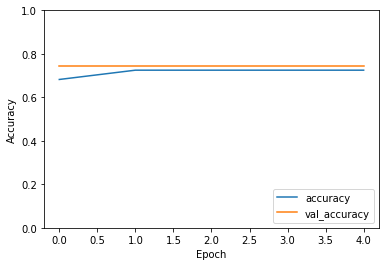

In [ ]:
# define the checkpoint
filepath = "Model_5-{epoch:02d}-{val_accuracy:.4f}.h5"
checkpoint = ModelCheckpoint(  
    filepath,
    monitor="val_accuracy",
    verbose=1,
    save_best_only=False,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch")

callbacks_list = [checkpoint]

# Training
history = model_5.fit(train_images, train_labels, epochs=5, batch_size=512,
                    validation_data=(test_images, test_labels), callbacks=callbacks_list)

# Validation
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model_5.evaluate(test_images,  test_labels, verbose=2)

print(test_acc)

In [ ]:
#specify the saved model from before
filepath = "/content/Model_5-05-0.7444.h5"

# load the model
new_model = load_model(filepath)

y_pred1 = new_model.predict(test_images)
y_pred = np.argmax(y_pred1, axis=1)

print(classification_report(test_labels, y_pred))

# Print f1, precision, and recall scores
print(precision_score(test_labels, y_pred , average="macro"))
print(recall_score(test_labels, y_pred , average="macro"))

print(f1_score(test_labels, y_pred , average="macro"))
print(f1_score(test_labels, y_pred , average="micro"))
print(f1_score(test_labels, y_pred , average="weighted"))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.00      0.00      0.00        50
           2       0.74      1.00      0.85       297
           3       0.00      0.00      0.00        28

    accuracy                           0.74       399
   macro avg       0.19      0.25      0.21       399
weighted avg       0.55      0.74      0.64       399

0.18609022556390978
0.25
0.21336206896551727
0.7443609022556391
0.6352735286492093


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
